In [1]:
!pip install openpyxl matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable


--- Starting Data Cleaning and Analysis Process ---
Step 1: Successfully loaded data. Initial shape: (43217, 7)

Step 2: Performed structural filtering (removed rows with any missing definitions or POS tags).
         Removed 5212 rows.
         Current shape: (38005, 7)

Step 3: Performed initial exact match filter.
         Removed 1594 rows where full and short definitions were identical.
         Current shape: (36411, 7)

Step 4: Analyzing and cleaning multi-part POS tags.
         Normalized POS tags where all parts were identical.
         Found 29 entries with inconsistent multi-part POS tags. Saved for review and removed from dataset.

Step 5: Cleaning self-referential parts from within multi-part full definitions.
         A total of 12030 entries had at least one long definition part removed.
         - 12024 entries had 1 part(s) removed.
         - 6 entries had 2 part(s) removed.

         Removed 0 rows that became empty after this cleaning.
         Current shape: (3638

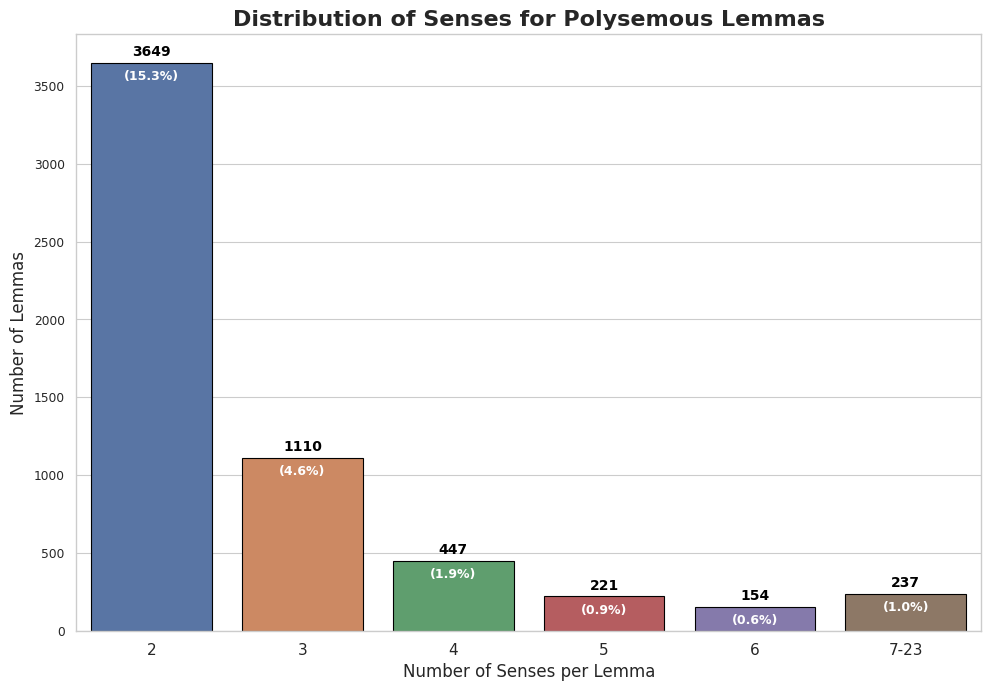


Step 17: Saving final review and cleaned datasets.
         Saved multi-part short definition review to 'definitions_mini_multi_def_review.tsv'.

         Cleaning complete. Final shape: (34824, 7)

--- Data Cleaning Summary ---
                         Step  Rows                                             Notes  Rows Removed % of Original
             1. Initial State 43217                         Data as loaded from file.             0        100.0%
      2. Structural Filtering 38005                 Removed rows with missing values.          5212        87.94%
3. Initial Exact Match Filter 36411                 Removed rows where Full == Short.          1594        84.25%
      4. Clean Multi-Part POS 36382      Removed inconsistent multi-part POS entries.            29        84.18%
 5. Surgical Self-Ref Removal 36382     Removed parts of Full def matching Short def.             0        84.18%
   6. Adv. Short Def Cleaning 36374 Cleaned Full defs based on multi-part Short defs. 

In [4]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

# ---
# CELL 1: Main Data Cleaning and Preparation Script
# ---

# --- Configuration ---
SHOW_DETAILED_REMOVAL_VIEW = False # Set to True to show a detailed breakdown of entries where 2 parts were removed.
SHOW_UNIQUE_OOK_PREFIXES = False # Set to True to print a list of unique phrases that precede 'ook: ' in deleted cases.

def analyze_and_clean_data(file_path, show_detailed_view=False, show_ook_prefixes=False):
    """
    Loads, analyzes, and cleans the definition dataset with a refined, multi-stage filtering logic.
    
    Args:
        file_path (str): The path to the raw .tsv file.
    
    Returns:
        pandas.DataFrame: The cleaned and prepared DataFrame.
    """
    print("--- Starting Data Cleaning and Analysis Process ---")
    stats_summary = []
    transformation_log = []

    # --- Step 1: Load Data ---
    try:
        df = pd.read_csv(file_path, sep='\t')
        initial_rows = len(df)
        print(f"Step 1: Successfully loaded data. Initial shape: {df.shape}")
        stats_summary.append({'Step': '1. Initial State', 'Rows': initial_rows, 'Notes': 'Data as loaded from file.'})
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Aborting.")
        return None

    # --- Step 2: Initial Structural Filtering ---
    df.dropna(subset=['DefinitionFull', 'DefinitionShort', 'POS'], inplace=True)
    rows_after_na = len(df)
    print(f"\nStep 2: Performed structural filtering (removed rows with any missing definitions or POS tags).")
    print(f"         Removed {initial_rows - rows_after_na} rows.")
    print(f"         Current shape: {df.shape}")
    stats_summary.append({'Step': '2. Structural Filtering', 'Rows': rows_after_na, 'Notes': 'Removed rows with missing values.'})

    # --- Step 3: Initial Exact Match Filter ---
    rows_before_initial_filter = len(df)
    df = df[df['DefinitionFull'] != df['DefinitionShort']].copy()
    rows_after_initial_filter = len(df)
    print(f"\nStep 3: Performed initial exact match filter.")
    print(f"         Removed {rows_before_initial_filter - rows_after_initial_filter} rows where full and short definitions were identical.")
    print(f"         Current shape: {df.shape}")
    stats_summary.append({'Step': '3. Initial Exact Match Filter', 'Rows': rows_after_initial_filter, 'Notes': 'Removed rows where Full == Short.'})

    # --- Step 4: Analyze and Clean Multi-Part POS Tags ---
    print("\nStep 4: Analyzing and cleaning multi-part POS tags.")
    
    def are_all_parts_same(pos_string):
        parts = str(pos_string).split()
        return len(set(parts)) <= 1

    # First, normalize the consistent multi-part POS tags
    def clean_consistent_pos(pos_string):
        parts = str(pos_string).split()
        if len(set(parts)) == 1:
            return parts[0]
        return pos_string

    df['POS'] = df['POS'].apply(clean_consistent_pos)
    print(f"         Normalized POS tags where all parts were identical.")

    # Now, identify and remove the remaining inconsistent cases
    inconsistent_pos_mask = df['POS'].astype(str).str.contains(' ', na=False)
    df_multi_pos_review = df[inconsistent_pos_mask].copy()

    if not df_multi_pos_review.empty:
        multi_pos_path = 'definitions_multi_pos_review.tsv'
        df_multi_pos_review.to_csv(multi_pos_path, sep='\t', index=False)
        print(f"         Found {len(df_multi_pos_review)} entries with inconsistent multi-part POS tags. Saved for review and removed from dataset.")
        
        # Remove the inconsistent entries
        df = df[~inconsistent_pos_mask].copy()
    else:
        print("         No entries with inconsistent multi-part POS tags found.")

    stats_summary.append({'Step': '4. Clean Multi-Part POS', 'Rows': len(df), 'Notes': 'Removed inconsistent multi-part POS entries.'})
    transformation_log.append({'Action': 'Clean Multi-Part POS', 'Detail': 'Removed entries with inconsistent POS tags.', 'Entries Affected': len(df_multi_pos_review)})


    # --- Step 5: Clean Self-Referential Parts from Full Definitions (Surgical Removal) ---
    print("\nStep 5: Cleaning self-referential parts from within multi-part full definitions.")
    rows_before_surgical_filter = len(df)

    # Store original definitions for later comparison
    df['Original_DefinitionFull_Step5'] = df['DefinitionFull']

    def clean_and_count_removals(row):
        vol_def, mini_def = str(row['DefinitionFull']), str(row['DefinitionShort'])
        original_parts = vol_def.split(';')
        
        cleaned_definitions = [d.strip() for d in original_parts if d.strip() != mini_def.strip()]
        
        num_removed = len(original_parts) - len(cleaned_definitions)
        new_def = '; '.join(cleaned_definitions)
        
        return pd.Series([new_def, num_removed])

    # Apply the function and get the counts
    df[['DefinitionFull_cleaned', 'removed_parts_count']] = df.apply(clean_and_count_removals, axis=1)

    # Analyze the number of removed parts
    removal_counts = df[df['removed_parts_count'] > 0]['removed_parts_count'].value_counts()
    total_affected_entries = removal_counts.sum()
    transformation_log.append({'Action': 'Remove Self-Referential Parts', 'Detail': 'A part of the full def matched the short def.', 'Entries Affected': total_affected_entries})


    print(f"         A total of {total_affected_entries} entries had at least one long definition part removed.")
    if total_affected_entries > 0:
        for num_removed, count in sorted(removal_counts.items()):
            print(f"         - {count} entries had {num_removed} part(s) removed.")

    # --- Detailed view for entries with 2 parts removed (Conditional) ---
    if show_detailed_view and 2 in removal_counts:
        print("\n         --- Detailed view of entries with 2 parts removed ---")
        pd.set_option('display.max_colwidth', None)
        df_two_removed = df[df['removed_parts_count'] == 2]
        print(df_two_removed[['Lemma', 'DefinitionShort', 'Original_DefinitionFull_Step5', 'DefinitionFull_cleaned']].rename(columns={
            'Original_DefinitionFull_Step5': 'Original Definition',
            'DefinitionFull_cleaned': 'Cleaned Definition'
        }).to_string())
        pd.reset_option('display.max_colwidth')
        print("         ----------------------------------------------------")


    # Update the main column and drop temporary ones
    df['DefinitionFull'] = df['DefinitionFull_cleaned']
    df.drop(columns=['DefinitionFull_cleaned', 'removed_parts_count', 'Original_DefinitionFull_Step5'], inplace=True)

    df['DefinitionFull'] = df['DefinitionFull'].replace('', np.nan)
    df.dropna(subset=['DefinitionFull'], inplace=True)
    rows_after_surgical_filter = len(df)
    
    print(f"\n         Removed {rows_before_surgical_filter - rows_after_surgical_filter} rows that became empty after this cleaning.")
    print(f"         Current shape: {df.shape}")
    stats_summary.append({'Step': '5. Surgical Self-Ref Removal', 'Rows': rows_after_surgical_filter, 'Notes': 'Removed parts of Full def matching Short def.'})

    # --- Step 6: Advanced Cleaning for Entries with Multi-Part Short Definitions ---
    print("\nStep 6: Advanced cleaning for entries with multi-part short definitions.")
    rows_before_adv_short_clean = len(df)
    multi_short_mask = df['DefinitionShort'].str.contains(';', na=False)
    
    def advanced_clean_definition(row):
        full_def_str, short_def_str = str(row['DefinitionFull']), str(row['DefinitionShort'])
        short_parts = {s.strip() for s in short_def_str.split(';')}
        full_parts = full_def_str.split(';')
        kept_full_parts = []
        for part in full_parts:
            stripped_part = part.strip()
            is_match = False
            if stripped_part in short_parts:
                is_match = True
            elif 'ook: ' in stripped_part:
                sub_part = stripped_part.split('ook: ', 1)[1].strip()
                if sub_part in short_parts:
                    is_match = True
            if not is_match:
                kept_full_parts.append(part)
        return '; '.join(kept_full_parts)

    df_subset_to_clean = df[multi_short_mask].copy()
    original_full_defs = df_subset_to_clean['DefinitionFull'].copy()
    df_subset_to_clean['DefinitionFull'] = df_subset_to_clean.apply(advanced_clean_definition, axis=1)
    modified_mask = original_full_defs != df_subset_to_clean['DefinitionFull']
    modified_lemmas = set(df_subset_to_clean[modified_mask]['Lemma'])
    print(f"         Found {len(modified_lemmas)} lemmas where at least one long definition part was removed.")
    transformation_log.append({'Action': 'Adv. Multi-Short Clean', 'Detail': 'A part of the full def matched a part of the multi-part short def.', 'Entries Affected': len(modified_lemmas)})

    empty_mask = df_subset_to_clean['DefinitionFull'].str.strip() == ''
    deleted_entries_count = empty_mask.sum()
    print(f"         This cleaning led to the complete removal of {deleted_entries_count} entries.")
    df.update(df_subset_to_clean)
    df['DefinitionFull'] = df['DefinitionFull'].replace('', np.nan)
    df.dropna(subset=['DefinitionFull'], inplace=True)
    print(f"         Current shape after this step: {df.shape}")
    stats_summary.append({'Step': '6. Adv. Short Def Cleaning', 'Rows': len(df), 'Notes': 'Cleaned Full defs based on multi-part Short defs.'})

    # --- Step 7: Analysis of Short Definitions ---
    print("\nStep 7: Analysis of short definitions.")
    mini_multi_def_mask = df['DefinitionShort'].str.contains(';', na=False)
    df_mini_review = df[mini_multi_def_mask].copy()
    # Storing original indices for final comparison
    mini_review_indices = df_mini_review.index
    print(f"          Found {len(df_mini_review)} entries with multi-part short definitions. They will be saved for review at the end.")

    # --- Step 8: Salvage Definitions Starting with 'ook: ' ---
    print("\nStep 8: Salvaging definitions that start with 'ook: '.")
    rows_before_salvage = len(df)
    
    def salvage_ook_defs(row):
        vol_def, mini_def = str(row['DefinitionFull']), str(row['DefinitionShort'])
        mini_def_parts = {p.strip() for p in mini_def.split(';')}
        definitions = vol_def.split(';')
        processed_definitions = []
        
        part_was_salvaged = False
        part_was_match_deleted = False

        for part in definitions:
            stripped_part = part.strip()
            if stripped_part.startswith('ook: '):
                salvaged_part = stripped_part.removeprefix('ook: ').strip()
                part_was_salvaged = True
                if salvaged_part not in mini_def_parts:
                    processed_definitions.append(salvaged_part)
                else:
                    part_was_match_deleted = True
            else:
                processed_definitions.append(part) # Keep non-'ook:' parts as they are

        return pd.Series(['; '.join(processed_definitions), part_was_salvaged, part_was_match_deleted])

    df[['DefinitionFull_cleaned', 'was_salvaged', 'was_match_deleted']] = df.apply(salvage_ook_defs, axis=1)
    
    salvaged_count = df['was_salvaged'].sum()
    match_deleted_count = df['was_match_deleted'].sum()
    print(f"         Salvaged at least one definition part in {salvaged_count} entries.")
    print(f"         After salvaging, {match_deleted_count} entries had a part deleted due to matching a short definition.")
    transformation_log.append({'Action': "Salvage 'ook:' Defs", 'Detail': 'A definition starting with "ook: " was cleaned.', 'Entries Affected': salvaged_count})


    df['DefinitionFull'] = df['DefinitionFull_cleaned']
    df.drop(columns=['DefinitionFull_cleaned', 'was_salvaged', 'was_match_deleted'], inplace=True)
    df['DefinitionFull'] = df['DefinitionFull'].replace('', np.nan)
    df.dropna(subset=['DefinitionFull'], inplace=True)
    
    print(f"         Removed {rows_before_salvage - len(df)} entries that became empty after this step.")
    print(f"         Current shape: {df.shape}")
    stats_summary.append({'Step': "8. Salvage 'ook:' Defs", 'Rows': len(df), 'Notes': "Cleaned definitions starting with 'ook: '."})

    # --- Step 9: Filter Definitions with Prefixed 'ook: ' ---
    print("\nStep 9: Filtering definitions with a prefix before 'ook: '.")
    
    # --- Analysis of 'ook: ' cases to be deleted (File Generation) ---
    print("         Analyzing 'ook: ' cases marked for deletion for review file.")
    rows_to_review_mask = df['DefinitionFull'].str.contains(r'[^;]\s*ook: ', na=False, regex=True)
    df_to_review = df[rows_to_review_mask]

    if not df_to_review.empty:
        ook_deletion_path = 'definitions_ook_deleted_cases.tsv'
        df_to_review.to_csv(ook_deletion_path, sep='\t', index=False)
        print(f"         Found {len(df_to_review)} entries containing definition parts to be deleted. Saved for analysis to '{ook_deletion_path}'.")
        transformation_log.append({'Action': "Filter Prefixed 'ook:'", 'Detail': 'A definition with a prefix before "ook: " was removed.', 'Entries Affected': len(df_to_review)})
        
        if show_ook_prefixes:
            preceding_phrases = set()
            for definition in df_to_review['DefinitionFull']:
                parts = definition.split(';')
                for part in parts:
                    stripped_part = part.strip()
                    if 'ook: ' in stripped_part and not stripped_part.startswith('ook: '):
                        phrase = stripped_part.split('ook: ', 1)[0].strip()
                        if phrase: preceding_phrases.add(phrase)
            
            if preceding_phrases:
                print("         (OPTIONAL) Found the following unique phrases preceding 'ook: ' in the deleted cases:")
                for phrase in sorted(list(preceding_phrases)): print(f"         - '{phrase}'")
            else: print("         (OPTIONAL) No cases with text preceding 'ook: ' were found in the set for deletion.")
    else:
        print("         No entries were found with definition parts to be deleted due to a prefix before 'ook: '.")
        transformation_log.append({'Action': "Filter Prefixed 'ook:'", 'Detail': 'A definition with a prefix before "ook: " was removed.', 'Entries Affected': 0})


    rows_before_prefix_filter = len(df)
    
    def filter_prefixed_ook(row):
        definitions = str(row['DefinitionFull']).split(';')
        # Keep only parts that DO NOT contain 'ook: ' with a prefix
        valid_definitions = [part for part in definitions if not ('ook: ' in part and not part.strip().startswith('ook: '))]
        return '; '.join(valid_definitions)

    df['DefinitionFull'] = df.apply(filter_prefixed_ook, axis=1)
    
    df['DefinitionFull'] = df['DefinitionFull'].replace('', np.nan)
    df.dropna(subset=['DefinitionFull'], inplace=True)
    
    print(f"         Removed {rows_before_prefix_filter - len(df)} entries that became empty after this filtering.")
    print(f"         Current shape: {df.shape}")
    stats_summary.append({'Step': "9. Filter Prefixed 'ook:'", 'Rows': len(df), 'Notes': "Removed definitions with prefixed 'ook: '."})


    # --- Step 10: Final Text Normalization (Whitespace) ---
    print("\nStep 10: Applying final text normalization (whitespace).")
    for col in ['DefinitionFull', 'DefinitionShort']:
        df[col] = df[col].astype(str).str.strip().str.replace(r'\s+', ' ', regex=True)
    
    # --- Step 11: Final Normalization to Single Definition ---
    print("\nStep 11: Normalizing to a single definition per entry by keeping the longest.")
    
    def get_longest_part(definition):
        parts = str(definition).split(';')
        if not parts: return ""
        return max(parts, key=lambda part: len(part.strip())).strip()

    # Normalize short definitions
    short_multi_mask = df['DefinitionShort'].str.contains(';', na=False)
    short_norm_count = short_multi_mask.sum()
    print(f"         Normalizing {short_norm_count} multi-part short definitions.")
    df.loc[short_multi_mask, 'DefinitionShort'] = df.loc[short_multi_mask, 'DefinitionShort'].apply(get_longest_part)
    transformation_log.append({'Action': 'Normalize to Single Def', 'Detail': 'Kept longest part of multi-part Short def.', 'Entries Affected': short_norm_count})


    # Normalize full definitions
    full_multi_mask = df['DefinitionFull'].str.contains(';', na=False)
    full_norm_count = full_multi_mask.sum()
    print(f"         Normalizing {full_norm_count} multi-part full definitions.")
    df.loc[full_multi_mask, 'DefinitionFull'] = df.loc[full_multi_mask, 'DefinitionFull'].apply(get_longest_part)
    stats_summary.append({'Step': '11. Single Def Normalization', 'Rows': len(df), 'Notes': 'Kept only the longest part of multi-part defs.'})
    transformation_log.append({'Action': 'Normalize to Single Def', 'Detail': 'Kept longest part of multi-part Full def.', 'Entries Affected': full_norm_count})


    # --- Step 12: Final Length and Match Filtering ---
    print("\nStep 12: Applying final length and exact match filters.")
    rows_before_final_filter = len(df)

    # Identify rows for deletion based on length
    len_deletion_mask = df['DefinitionFull'].str.len() < df['DefinitionShort'].str.len()
    df_deleted_len = df[len_deletion_mask].copy()
    df_deleted_len['Deletion_Reason'] = 'Full definition shorter than short'

    # Identify rows for deletion based on exact match (from the remaining set)
    remaining_df = df[~len_deletion_mask]
    match_deletion_mask = remaining_df['DefinitionFull'] == remaining_df['DefinitionShort']
    df_deleted_match = remaining_df[match_deletion_mask].copy()
    df_deleted_match['Deletion_Reason'] = 'Full definition matches short'

    # Combine the deleted rows for the review file
    df_deleted_in_step12 = pd.concat([df_deleted_len, df_deleted_match])

    # Save the deleted rows to a file
    if not df_deleted_in_step12.empty:
        deleted_rows_path = 'definitions_final_deletions.tsv'
        df_deleted_in_step12.to_csv(deleted_rows_path, sep='\t', index=False)
        print(f"         Saved {len(df_deleted_in_step12)} entries marked for final deletion to '{deleted_rows_path}'.")

    # Print the breakdown
    print(f"         Removed {len(df_deleted_len)} entries where the final full definition was shorter than the short one.")
    print(f"         Removed {len(df_deleted_match)} additional entries where the final full and short definitions were identical.")

    # Apply the filters to the main dataframe
    df = df[~len_deletion_mask] # remove short ones
    df = df[df['DefinitionFull'] != df['DefinitionShort']] # remove matches from the remainder
    
    print(f"         Total removed in this step: {rows_before_final_filter - len(df)} entries.")
    print(f"         Current shape: {df.shape}")
    stats_summary.append({'Step': '12. Final Length/Match Filter', 'Rows': len(df), 'Notes': 'Final cleanup of invalid entries.'})

    # --- Step 13: Single-Word Definition Analysis ---
    print("\nStep 13: Analyzing single-word definitions.")

    def is_single_word(text):
        # A word is a sequence of non-whitespace characters.
        return len(str(text).split()) == 1

    # Analyze short definitions
    single_word_short_mask = df['DefinitionShort'].apply(is_single_word)
    print(f"         Found {single_word_short_mask.sum()} entries where the final short definition is a single word.")

    # Analyze full definitions
    single_word_full_mask = df['DefinitionFull'].apply(is_single_word)
    df_single_word_full = df[single_word_full_mask].copy()

    if not df_single_word_full.empty:
        single_word_full_path = 'definitions_single_word_full_defs.tsv'
        df_single_word_full.to_csv(single_word_full_path, sep='\t', index=False)
        print(f"         Found {len(df_single_word_full)} entries where the final full definition is a single word. Saved for review to '{single_word_full_path}'.")
    else:
        print("         Found no entries where the final full definition is a single word.")
    
    stats_summary.append({'Step': '13. Single Word Analysis', 'Rows': len(df), 'Notes': 'Analysis step, no rows removed.'})

    # --- Step 14: Filter Single-Word Full Definitions ---
    print("\nStep 14: Filtering out entries with single-word full definitions.")
    rows_before_single_word_filter = len(df)
    
    # Use the mask from the previous step to remove the rows
    df = df[~single_word_full_mask].copy()
    
    print(f"         Removed {rows_before_single_word_filter - len(df)} entries where the final full definition was a single word.")
    
    # Recount the number of single-word short definitions in the final dataset
    final_single_word_short_mask = df['DefinitionShort'].apply(is_single_word)
    print(f"         After filtering, {final_single_word_short_mask.sum()} entries remain with a single-word short definition.")
    
    print(f"         Current shape: {df.shape}")
    stats_summary.append({'Step': '14. Filter Single Word Full', 'Rows': len(df), 'Notes': 'Removed entries where Full def is one word.'})

    # --- Step 15: Final Dataset Statistics ---
    print("\nStep 15: Analyzing final dataset statistics.")
    
    # --- Definition Length Statistics ---
    print("\n         --- Definition Length Statistics (Characters) ---")
    len_stats_short = df['DefinitionShort'].str.len().describe()
    len_stats_full = df['DefinitionFull'].str.len().describe()
    len_stats_df = pd.DataFrame({'Short Definition': len_stats_short, 'Full Definition': len_stats_full})
    print(len_stats_df.round(2).to_string())

    print("\n         --- Definition Length Statistics (Words) ---")
    word_stats_short = df['DefinitionShort'].str.split().str.len().describe()
    word_stats_full = df['DefinitionFull'].str.split().str.len().describe()
    word_stats_df = pd.DataFrame({'Short Definition': word_stats_short, 'Full Definition': word_stats_full})
    print(word_stats_df.round(2).to_string())
    
    # --- Part-of-Speech (POS) Distribution ---
    print("\n         --- Part-of-Speech (POS) Distribution ---")
    pos_counts = df['POS'].value_counts()
    pos_percentages = (df['POS'].value_counts(normalize=True) * 100).round(2)
    pos_df = pd.DataFrame({'Count': pos_counts, 'Percentage (%)': pos_percentages})
    print(pos_df.to_string())
    
    # --- Lemma Analysis ---
    print("\n         --- Lemma Composition Analysis ---")
    is_abbreviation = df['Lemma'].str.contains(r'\.', regex=True) | (df['Lemma'].str.isupper() & (df['Lemma'].str.len() > 1))
    is_hyphenated = df['Lemma'].str.contains('-') & ~is_abbreviation
    has_apostrophe = df['Lemma'].str.contains("'") & ~is_abbreviation & ~is_hyphenated
    has_numbers = df['Lemma'].str.contains(r'\d') & ~is_abbreviation & ~is_hyphenated & ~has_apostrophe
    is_alpha = df['Lemma'].str.match(r'^[a-zA-Z\s]+$') & ~is_abbreviation & ~is_hyphenated & ~has_apostrophe & ~has_numbers
    other = ~is_abbreviation & ~is_hyphenated & ~has_apostrophe & ~has_numbers & ~is_alpha
    
    print(f"         - Purely Alphabetic (A-Z, a-z, space): {is_alpha.sum()}")
    print(f"         - Abbreviations (contains '.' or ALL CAPS): {is_abbreviation.sum()}")
    print(f"         - Hyphenated (contains '-'): {is_hyphenated.sum()}")
    print(f"         - Contains Apostrophe (contains '\''): {has_apostrophe.sum()}")
    print(f"         - Contains Numbers: {has_numbers.sum()}")
    print(f"         - Other/Special Characters: {other.sum()}")
    print(f"         -----------------------------------------")
    print(f"         Total Lemmas Analyzed: {len(df)}")
    
    # --- Polysemy Analysis ---
    print("\n         --- Polysemy Analysis ---")
    lemma_counts = df['Lemma'].value_counts()
    unique_lemmas_count = len(lemma_counts)
    polysemous_lemmas_count = (lemma_counts > 1).sum()
    single_sense_lemmas_count = unique_lemmas_count - polysemous_lemmas_count

    print(f"         - Total unique lemmas: {unique_lemmas_count}")
    print(f"         - Lemmas with a single sense: {single_sense_lemmas_count}")
    print(f"         - Polysemous lemmas (>=2 senses): {polysemous_lemmas_count}")

    if polysemous_lemmas_count > 0:
        print("\n         Distribution of senses for polysemous lemmas:")
        sense_distribution = lemma_counts[lemma_counts > 1].value_counts().sort_index()
        for senses, count in sense_distribution.items():
            print(f"         - {count} lemmas have {senses} senses.")
            
    stats_summary.append({'Step': '15. Final Dataset Analysis', 'Rows': len(df), 'Notes': 'Analysis step, no rows removed.'})


    


    # --- Step 16: Generate Data Visualizations ---
    print("\nStep 16: Generating data visualizations.")
    
    # Set plot style for thesis-quality aesthetics
    sns.set_theme(style="whitegrid", context="paper")

    # --- Plot 1: POS Distribution (EDITED) ---
    plt.figure(figsize=(10, 7))
    
    pos_percentages = df['POS'].value_counts(normalize=True) * 100
    pos_counts = df['POS'].value_counts()
    
    threshold = 1.0
    other_tags_perc = pos_percentages[pos_percentages < threshold]
    pos_to_plot_perc = pos_percentages[pos_percentages >= threshold].copy()
    pos_to_plot_abs = pos_counts[pos_percentages >= threshold].copy()

    if not other_tags_perc.empty:
        other_category_name = 'Other POS'
        pos_to_plot_perc[other_category_name] = other_tags_perc.sum()
        pos_to_plot_abs[other_category_name] = pos_counts[pos_percentages < threshold].sum()

    pos_to_plot_perc.index = pos_to_plot_perc.index.str.capitalize()
    pos_to_plot_abs.index = pos_to_plot_abs.index.str.capitalize()
    
    pos_to_plot_perc = pos_to_plot_perc.sort_values(ascending=False)
    pos_to_plot_abs = pos_to_plot_abs.reindex(pos_to_plot_perc.index)

    # Add black outline to bars
    ax = sns.barplot(x=pos_to_plot_perc.index, y=pos_to_plot_perc.values, hue=pos_to_plot_perc.index, palette="deep", legend=False, edgecolor='black')
    ax.set_title('Part-of-Speech Distribution in the Final Dataset', fontsize=14, weight='bold')
    ax.set_xlabel('Part-of-Speech', fontsize=12)
    ax.set_ylabel('Percentage (%)', fontsize=12)
    ax.set_yscale('log')
    
    # Set x-axis labels to be horizontal
    plt.xticks(rotation=0, ha='center', fontsize=11)
    
    # --- Y-axis Tick Formatting (EDITED) ---
    custom_ticks = sorted(list(pos_to_plot_perc.values) + [10, 20, 40, 60])
    ax.set_yticks(custom_ticks)
    ax.get_yaxis().set_major_formatter(mticker.FuncFormatter(lambda y, p: f'{y:.1f}%'))
    # Adjust y-axis limit to give more space at the top
    ax.set_ylim(bottom=0.5, top=max(custom_ticks)*1.3)

    for i, p in enumerate(ax.patches):
        percentage = p.get_height()
        absolute_count = pos_to_plot_abs.iloc[i]
        
        ax.annotate(f'{int(absolute_count)}',
                    (p.get_x() + p.get_width() / 2., percentage),
                    ha='center', va='center',
                    fontsize=9, color='black', weight='bold',
                    xytext=(0, 8),
                    textcoords='offset points')
        
        ax.annotate(f'{percentage:.1f}%',
                    (p.get_x() + p.get_width() / 2., percentage),
                    ha='center', va='top',
                    fontsize=10, color='white', weight='bold',
                    xytext=(0, -4),
                    textcoords='offset points')
    
    plt.tight_layout()
    plt.savefig('pos_distribution.png', dpi=300)
    print("         Saved POS distribution plot to 'pos_distribution.png'.")
    plt.close()

    # --- Plots 2-5: Definition Length Distributions (REVISED) ---
    # Prepare data once
    word_plot_data = pd.concat([
        pd.DataFrame({'Length': df['DefinitionShort'].str.split().str.len(), 'Type': 'Short Definition'}),
        pd.DataFrame({'Length': df['DefinitionFull'].str.split().str.len(), 'Type': 'Full Definition'})
    ], ignore_index=True)

    char_plot_data = pd.concat([
        pd.DataFrame({'Length': df['DefinitionShort'].str.len(), 'Type': 'Short Definition'}),
        pd.DataFrame({'Length': df['DefinitionFull'].str.len(), 'Type': 'Full Definition'})
    ], ignore_index=True)

    # Plot 2: Word Count Box Plot (No outliers)
    plt.figure(figsize=(8, 6))
    ax_box_word = sns.boxplot(x='Type', y='Length', data=word_plot_data, hue='Type', palette="muted", legend=False, showfliers=False, showmeans=True, meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"8"})
    ax_box_word.set_title('Definition Length (Words)\n(Outliers not shown for clarity)', fontsize=14, weight='bold')
    ax_box_word.set_xlabel('')
    ax_box_word.set_ylabel('Word Count', fontsize=12)
    plt.tight_layout()
    plt.savefig('definition_length_boxplot_words.png', dpi=300)
    print("         Saved definition length (words, boxplot) to 'definition_length_boxplot_words.png'.")
    plt.close()

    # Plot 3: Word Count Histogram
    plt.figure(figsize=(8, 5))
    ax_hist_word = sns.histplot(data=word_plot_data, x='Length', hue='Type', 
                multiple="layer", palette="muted", discrete=True,
                stat="density", common_norm=False, edgecolor='black')
    ax_hist_word.set_title('Definition Length (Words) - Distribution', fontsize=14, weight='bold')
    ax_hist_word.set_xlabel('Word Count', fontsize=12)
    ax_hist_word.set_ylabel('Density', fontsize=12)
    ax_hist_word.set_xlim(0, 40)
    plt.tight_layout()
    plt.savefig('definition_length_hist_words.png', dpi=300)
    print("         Saved definition length (words, histogram) to 'definition_length_hist_words.png'.")
    plt.close()

    # Plot 4: Character Count Box Plot (No outliers)
    plt.figure(figsize=(8, 6))
    ax_box_char = sns.boxplot(x='Type', y='Length', data=char_plot_data, hue='Type', palette="muted", legend=False, showfliers=False, showmeans=True, meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"8"})
    ax_box_char.set_title('Definition Length (Characters)\n(Outliers not shown for clarity)', fontsize=14, weight='bold')
    ax_box_char.set_xlabel('')
    ax_box_char.set_ylabel('Character Count', fontsize=12)
    plt.tight_layout()
    plt.savefig('definition_length_boxplot_chars.png', dpi=300)
    print("         Saved definition length (chars, boxplot) to 'definition_length_boxplot_chars.png'.")
    plt.close()

    # Plot 5: Character Count Histogram
    plt.figure(figsize=(8, 5))
    ax_hist_char = sns.histplot(data=char_plot_data, x='Length', hue='Type', 
                multiple="layer", palette="muted",
                stat="density", common_norm=False, edgecolor='black')
    ax_hist_char.set_title('Definition Length (Characters) - Distribution', fontsize=14, weight='bold')
    ax_hist_char.set_xlabel('Character Count', fontsize=12)
    ax_hist_char.set_ylabel('Density', fontsize=12)
    ax_hist_char.set_xlim(0, 300)
    plt.tight_layout()
    plt.savefig('definition_length_hist_chars.png', dpi=300)
    print("         Saved definition length (chars, histogram) to 'definition_length_hist_chars.png'.")
    plt.close()

    # --- Plot 6: Polysemy Distribution (EDITED) ---
    plt.figure(figsize=(10, 7))
    # --- Calculations ---
    lemma_counts = df['Lemma'].value_counts()
    # Denominator for percentage calculation: total number of unique lemmas
    total_unique_lemmas = len(lemma_counts)
    # Filter for polysemous lemmas (2 or more senses)
    sense_distribution = lemma_counts[lemma_counts > 1].value_counts().sort_index()

    # --- Grouping for cleaner plotting (as in original script) ---
    cutoff = 7
    poly_to_plot = sense_distribution[sense_distribution.index < cutoff].copy()
    # Check if there are lemmas with 'cutoff' or more senses
    if not sense_distribution[sense_distribution.index >= cutoff].empty:
        max_senses = sense_distribution.index.max()
        # Sum lemmas with 'cutoff' or more senses into a single category
        poly_to_plot[f'{cutoff}-{max_senses}'] = sense_distribution[sense_distribution.index >= cutoff].sum()

    poly_to_plot_x = poly_to_plot.index.astype(str)

    # --- Plotting ---
    ax = sns.barplot(x=poly_to_plot_x, y=poly_to_plot.values, hue=poly_to_plot_x, palette="deep", legend=False, edgecolor='black')
    ax.set_title('Distribution of Senses for Polysemous Lemmas', fontsize=16, weight='bold')
    ax.set_xlabel('Number of Senses per Lemma', fontsize=12)
    ax.set_ylabel('Number of Lemmas', fontsize=12)
    plt.xticks(fontsize=11)

    # --- REVISED ANNOTATION LOOP ---
    # This loop now adds both the absolute count and the calculated percentage to each bar
    for p in ax.patches:
        absolute_count = p.get_height()
        # Calculate percentage against the total number of unique lemmas
        percentage = (absolute_count / total_unique_lemmas) * 100
    
        # Annotation for the absolute count (placed above the bar)
        ax.annotate(f'{int(absolute_count)}',
                    (p.get_x() + p.get_width() / 2., absolute_count),
                    ha='center', va='center',
                    fontsize=10, color='black', weight='bold',
                    xytext=(0, 8),
                    textcoords='offset points')
                
        # Annotation for the percentage (placed inside the bar, near the top)
        ax.annotate(f'({percentage:.1f}%)',
                    (p.get_x() + p.get_width() / 2., absolute_count),
                    ha='center', va='top',
                    fontsize=9, color='white', weight='bold',
                    xytext=(0, -5),
                    textcoords='offset points')

    plt.tight_layout()
    # Save the new plot with a different name to avoid overwriting the original
    plt.savefig('polysemy_distribution_with_percentages.png', dpi=300)
    print(f"Chart saved to 'polysemy_distribution_with_percentages.png'")
    plt.show() # Use plt.show() to display the plot in a notebook environment
    plt.close()

    stats_summary.append({'Step': '16. Generate Visualizations', 'Rows': len(df), 'Notes': 'Analysis step, no rows removed.'})


    # --- Step 17: Save Final Review and Cleaned Datasets ---
    print("\nStep 17: Saving final review and cleaned datasets.")
    
    # --- Create the enhanced review file for multi-part short definitions ---
    mini_review_path_tsv = 'definitions_mini_multi_def_review.tsv'
    
    # Get the final chosen short definitions for the review set
    final_short_defs = df.loc[df.index.intersection(mini_review_indices), 'DefinitionShort']
    
    # Add the final choice as a new column to the original review dataframe
    df_mini_review['Final_Chosen_Short_Def'] = final_short_defs
    
    # Save the result to a TSV file
    df_mini_review.to_csv(mini_review_path_tsv, sep='\t', index=False)
    print(f"         Saved multi-part short definition review to '{mini_review_path_tsv}'.")


    # --- Save the main cleaned dataset ---
    output_path = 'definitions_clean.tsv'
    df.to_csv(output_path, sep='\t', index=False)
    print(f"\n         Cleaning complete. Final shape: {df.shape}")
    
    # --- Final Summary Table ---
    print("\n--- Data Cleaning Summary ---")
    summary_df = pd.DataFrame(stats_summary)
    summary_df['Rows Removed'] = -summary_df['Rows'].diff().fillna(0).astype(int)
    summary_df.loc[0, 'Rows Removed'] = 0 # Set the first row's removal to 0
    
    initial_row_count = summary_df.loc[0, 'Rows']
    summary_df['% of Original'] = ((summary_df['Rows'] / initial_row_count) * 100).round(2).astype(str) + '%'
    
    print(summary_df.to_string(index=False))
    
    # --- Data Transformation Log ---
    print("\n--- Data Transformation Log ---")
    transformation_df = pd.DataFrame(transformation_log)
    print(transformation_df.to_string(index=False))
    print("-" * 27)


    return df

# ---
# CELL 2: Execution
# ---

# Define the path to your raw data file
raw_file_path = 'definitions_run1.tsv'

if __name__ == '__main__':
    cleaned_df = analyze_and_clean_data(file_path=raw_file_path, 
                                        show_detailed_view=SHOW_DETAILED_REMOVAL_VIEW, 
                                        show_ook_prefixes=SHOW_UNIQUE_OOK_PREFIXES)